In [1]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import torch
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter, NLTKTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from sentence_transformers import SentenceTransformer
from langchain.embeddings import GPT4AllEmbeddings

search_query = "What are your refund policies?"
search_query = re.sub(r'\bDaraz\b\s*', '', search_query, flags=re.IGNORECASE)
file_name = "DarazDataMain.txt"
chunkSize = 1500

with open(file_name, 'r', encoding="utf8") as f:
    products = f.readlines()

In [2]:
model = SentenceTransformer('all-MiniLM-L6-v2')
product_embeddings = model.encode(products, convert_to_tensor=True)

def search_products(query, k):
    query_embedding = model.encode(query, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(query_embedding, product_embeddings)[0]
    top_results = torch.topk(cosine_scores, k=k)

    print("Query:", query)
    for score, idx in zip(top_results[0], top_results[1]):
        print("\nScore:", score.item())
        print("Product Details:", products[idx])

search_products(search_query, 2)

Query: What are your refund policies?

Score: 0.5706478953361511
Product Details: 1.19 “Returns and Refunds Policy” shall mean the applicable Company policies which govern the procedure for returns and refunds of Products by Customers on the relevant Channels located at Returns and Refunds Policy of Pakistan.


Score: 0.549439549446106
Product Details: Home & Living Bedding & Bath, Furniture & Lighting, Kitchen & Dining, Home Décor, Home Improvements, Household & Home Storage Supplies, Lawn & Garden,Other Accessories Change of mind isnot applicable for return and refund. If the item received is damaged, defective, incorrect, or incomplete, a refund will be issued based on Daraz's assessment. Note: For device-related issues after usage or expiration of return policy period, please check if the item is covered under Seller orBrand Warranty. Refer to our Warranty Policy for information on the different warranty types and ways to contact the seller/manufacturer. Items that are non-returnab

In [3]:
query = search_query
loader = TextLoader(file_name)
docs = loader.load()

In [4]:
chunker01 = "Fixed-size (in characters) Overlapping Sliding Window"

text_splitter = CharacterTextSplitter(separator="\n", chunk_size=chunkSize, chunk_overlap=20)
splits = text_splitter.split_documents(docs)

persist_directory = 'chroma/' + str(file_name) + " - Chunker = " + chunker01
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=GPT4AllEmbeddings(),
    persist_directory=persist_directory
)
vectordb.persist()
docs01 = vectordb.similarity_search_with_score(query, k=2)

Created a chunk of size 26958, which is longer than the specified 1500
Created a chunk of size 2500, which is longer than the specified 1500
Created a chunk of size 2032, which is longer than the specified 1500
Created a chunk of size 1537, which is longer than the specified 1500
Created a chunk of size 1662, which is longer than the specified 1500
Created a chunk of size 2178, which is longer than the specified 1500
Created a chunk of size 1608, which is longer than the specified 1500
Created a chunk of size 2486, which is longer than the specified 1500
Created a chunk of size 2510, which is longer than the specified 1500
Created a chunk of size 1754, which is longer than the specified 1500
Created a chunk of size 3013, which is longer than the specified 1500


In [5]:
chunker02 = "Recursive Structure Aware Splitting"

text_splitter = RecursiveCharacterTextSplitter(separators = ["\n\n", "\n"], chunk_size=chunkSize, chunk_overlap=20)
splits = text_splitter.split_documents(docs)

persist_directory = 'chroma/' + str(file_name) + " - Chunker = " + chunker02
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=GPT4AllEmbeddings(),
    persist_directory=persist_directory
)
vectordb.persist()
docs02 = vectordb.similarity_search_with_score(query, k=2)

In [6]:
chunker03 = "NLP Chunking: Tracking Topic Changes"

text_splitter = NLTKTextSplitter(chunk_size=chunkSize)#, separator="\n")
splits = text_splitter.split_documents(docs)

persist_directory = 'chroma/' + str(file_name) + " - Chunker = " + chunker03
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=GPT4AllEmbeddings(),
    persist_directory=persist_directory
)
vectordb.persist()
docs03 = vectordb.similarity_search_with_score(query, k=2)

Created a chunk of size 2157, which is longer than the specified 1500
Created a chunk of size 1692, which is longer than the specified 1500
Created a chunk of size 1967, which is longer than the specified 1500
Created a chunk of size 1830, which is longer than the specified 1500


In [7]:
print("question = \"" + query + "\"")

with open("outputMain.txt", "w") as file:
    count = 1
    for result in docs01:
        file.write(f"response{count} = \"{result[0].page_content}\"\n")
        count += 1

    count = 1
    for result in docs02:
        file.write(f"response{count} = \"{result[0].page_content}\"\n")
        count += 1

    count = 1
    for result in docs03:
        file.write(f"response{count} = \"{result[0].page_content}\"\n")
        count += 1

question = "What are your refund policies?"


In [8]:
import re
import textwrap

def clean_text(text):
    # Remove any image file references
    text = re.sub(r"\S+\.(png|jpg|jpeg|gif)\s*", "", text)

    # Normalize spacing issues
    text = re.sub(r"\s+", " ", text).strip()

    # Correct common typographical errors
    text = re.sub(r"isnot", "is not", text)
    text = re.sub(r"orBrand", "or Brand", text)
    text = re.sub(r"ourWarranty", "our Warranty", text)

    # Remove redundant response indicators
    text = re.sub(r"response\d+\s*=\s*\"", "", text)

    # Remove numbers followed by a dot, e.g., "1."
    text = re.sub(r"\d+\.", "", text)

    # Remove numbers followed directly by a dash, e.g., "2-"
    text = re.sub(r"\d+-", "", text)

    # Deduplicate text
    lines = text.split('.')
    seen = set()
    unique_lines = []
    for line in lines:
        line_clean = line.strip()
        if line_clean not in seen:
            seen.add(line_clean)
            unique_lines.append(line_clean)

    # Reconstruct text with clean lines
    cleaned_text = '. '.join(unique_lines).strip()
    if not cleaned_text.endswith('.'):
        cleaned_text += '.'

    # Split into multiple lines with a reasonable width
    wrapped_text = textwrap.fill(cleaned_text, width=100)

    return wrapped_text

with open('outputMain.txt', 'r') as file:
    raw_text = file.read()
    
cleaned_text = clean_text(raw_text)

with open('outputMain.txt', 'w') as file:
    file.write(cleaned_text)

In [9]:
loader = TextLoader("outputMain.txt")
docs = loader.load()

text_splitter = CharacterTextSplitter(separator="\n", chunk_size=chunkSize, chunk_overlap=0)
splits = text_splitter.split_documents(docs)

persist_directory = 'chroma/' + str(file_name) + " - On Final Clean Output"
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=GPT4AllEmbeddings(),
    persist_directory=persist_directory
)
vectordb.persist()
docs = vectordb.similarity_search_with_score(query, k=2)

In [10]:
print("question = \"" + query + "\"")
count = 1
for result in docs:
    print(f"response" + str(count) + " = \"" + result[0].page_content + "\"")  
    count+=1

question = "What are your refund policies?"
response1 = "Home & Living Bedding & Bath, Furniture & Lighting, Kitchen & Dining, Home Décor, Home Improvements,
Household & Home Storage Supplies, Lawn & Garden,Other Accessories Change of mind is not applicable
for return and refund. If the item received is damaged, defective, incorrect, or incomplete, a
refund will be issued based on Daraz's assessment. Note: For device-related issues after usage or
expiration of return policy period, please check if the item is covered under Seller or Brand
Warranty. Refer to our Warranty Policy for information on the different warranty types and ways to
contact the seller/manufacturer. Items that are non-returnable: Any custom-made items" What is the
cancellation and return policy for Buy More, Save More orders? Partial cancellations are not allowed
but partial returns are allowed on Buy More, Save More orders i. e. you will not be able to cancel 1
or 2 products in your order and would instead have to c

In [11]:
# with open('output.txt', 'r') as file:
#     content = file.readlines()

![Screenshot 2024-04-26 at 9.06.54 PM.jpeg](<attachment:Screenshot 2024-04-26 at 9.06.54 PM.jpeg>)
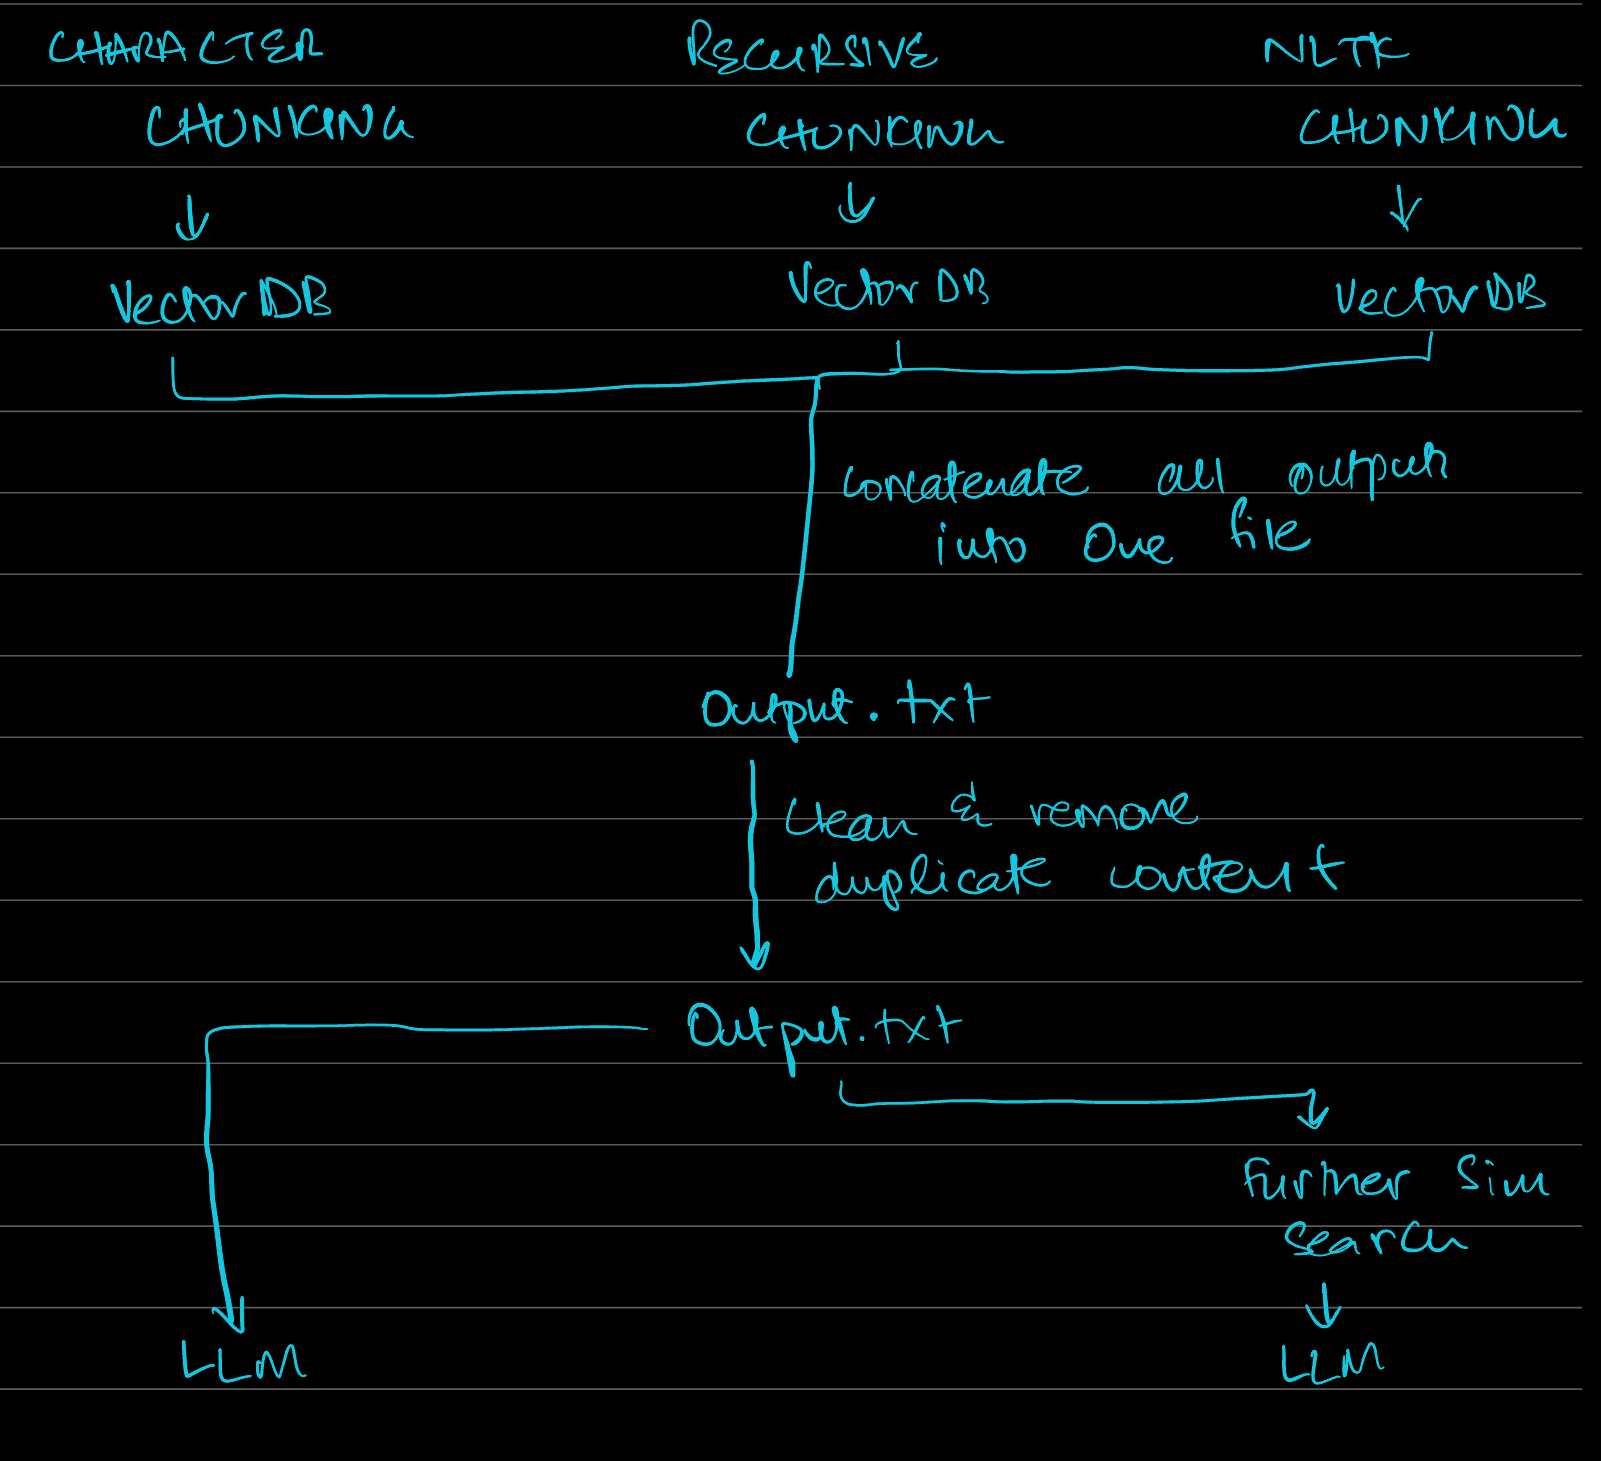